In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize, fsolve
from itertools import product
from tqdm import tqdm

import warnings 
warnings.filterwarnings('ignore')

In [2]:
'''
file_path = 'e://test.log.txt'
test_log = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')
test_log['timestamp'] = pd.to_datetime(test_log['timestamp'], format='%Y%m%d%H%M%S%f')
test_log = test_log.sort_values('timestamp')

for x in test_log.columns:
    if test_log[x].dtype == 'object':
        test_log[x] = test_log[x].astype(str)

test_log.to_feather('test_log.ftr')
'''

"\nfile_path = 'e://test.log.txt'\ntest_log = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')\ntest_log['timestamp'] = pd.to_datetime(test_log['timestamp'], format='%Y%m%d%H%M%S%f')\ntest_log = test_log.sort_values('timestamp')\n\nfor x in test_log.columns:\n    if test_log[x].dtype == 'object':\n        test_log[x] = test_log[x].astype(str)\n\ntest_log.to_feather('test_log.ftr')\n"

In [4]:
df = pd.read_feather('test_log.ftr')
print(df.columns)
display(df.head())

Index(['click', 'weekday', 'hour', 'bidid', 'timestamp', 'logtype',
       'ipinyouid', 'useragent', 'IP', 'region', 'city', 'adexchange',
       'domain', 'url', 'urlid', 'slotid', 'slotwidth', 'slotheight',
       'slotvisibility', 'slotformat', 'slotprice', 'creative', 'bidprice',
       'payprice', 'keypage', 'advertiser', 'usertag', 'nclick',
       'nconversation'],
      dtype='object')


,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag,nclick,nconversation
0,0,4,0,82aed71bea7358c9a5be868deae30be0,2013-06-13 00:01:01.373,1,Vh5KZAnrPQTPJIC,windows_chrome,60.187.41.*,94,...,1,0,cc9b344e950b4f8c2b96537174a343b7,227,29,d29e59bf0f7f8243858b8183f14d4412,3358,10063,0,0
1,0,4,0,77c5c149c234a0de420eefe9b6e16517,2013-06-13 00:01:01.391,1,Vh1HP3FpOUx6kgL,windows_chrome,221.0.14.*,146,...,1,0,fa8f0532dd5144b5fa748459e8d90b49,227,20,0f951a030abdaedd733ee8d114ce2944,3427,"13403,10006,10063,13866,10126,10117,10110",0,0
2,0,4,0,a45fe947ffb7a52f452308bb50b4a572,2013-06-13 00:01:01.428,1,Vh5zPuc9DvT2lGk,windows_theworld,180.173.50.*,79,...,0,5,7184c9560e68e977187e67e45a4f3198,238,63,0f951a030abdaedd733ee8d114ce2944,3427,"13042,10052,10075,10006,10031,10063,13800,1013...",0,0
3,0,4,0,184d6f9a71c3c53336cff407e5b7ae,2013-06-13 00:01:01.438,1,Vh5KZAnrPoddkMf,windows_chrome,175.148.162.*,40,...,5,0,44966cc8da1ed40c95d59e863c8c75f0,300,293,361e128affece850342293213691a043,3386,"13866,10111",0,0
4,0,4,0,11415ce7ca9c7e1950b41bf3468fb288,2013-06-13 00:01:01.456,1,VhdiPkNq3QNvwQL,windows_chrome,111.179.205.*,183,...,1,0,911b2d84826786018761e8c0b0a3a60c,227,120,d29e59bf0f7f8243858b8183f14d4412,3358,"13042,10031,10063,10006,10075,10126,10116,10110",0,0


## 6.0 Data Analysis

In [6]:
def remove_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    lower_bound = q1 - 1.5 * (q3 - q1)
    upper_bound = q3 + 1.5 * (q3 - q1)
    return data[(data >= lower_bound) & (data <= upper_bound)]

KS Statistic: 0.1727490106918422, p-value: 0.0


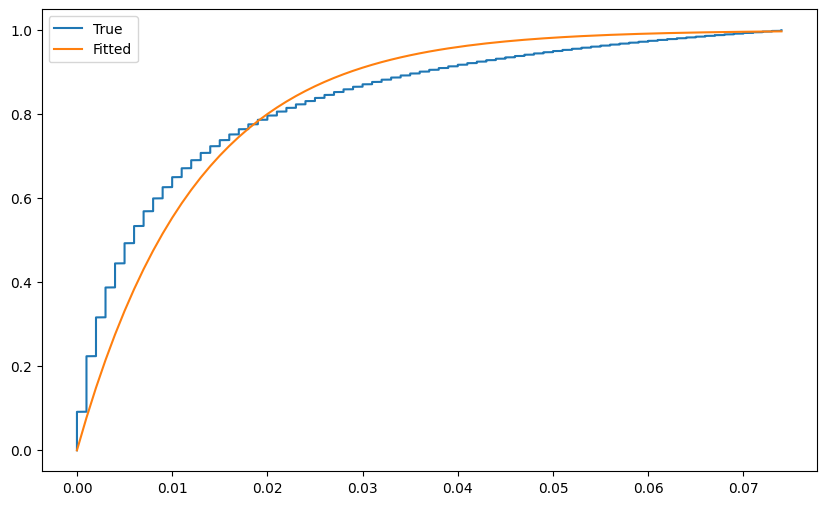

In [7]:
# testing poisson arrival
df['interval'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
interval = remove_outlier(df['interval']).sort_values()
true = np.arange(len(interval)) / len(interval)
loc, scale = stats.expon.fit(interval)
fitted = stats.expon.cdf(interval, loc=loc, scale=scale)

kstest = stats.kstest(interval, 'expon', args=(loc, scale))
print(f'KS Statistic: {kstest.statistic}, p-value: {kstest.pvalue}')

plt.figure(figsize=(10, 6))
plt.plot(interval, true, label='True')
plt.plot(interval, fitted, label='Fitted')
plt.legend()
plt.show()

KS Statistic: 0.14300376445527607, p-value: 0.0


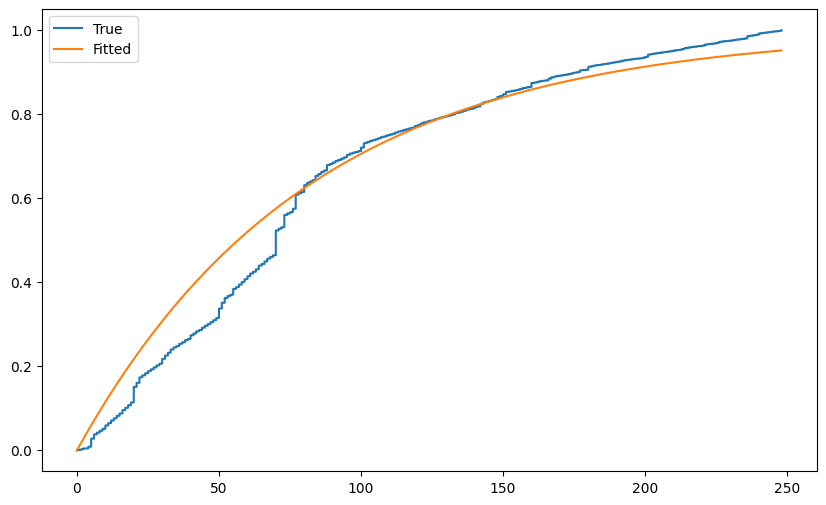

In [8]:
payprice = remove_outlier(df['payprice']).sort_values()
true = np.arange(len(payprice)) / len(payprice)
loc, scale = stats.expon.fit(payprice)
fitted = stats.expon.cdf(payprice, loc=loc, scale=scale)
kstest = stats.kstest(payprice, 'expon', args=(loc, scale))
print(f'KS Statistic: {kstest.statistic}, p-value: {kstest.pvalue}')

plt.figure(figsize=(10, 6))
plt.plot(payprice, true, label='True')
plt.plot(payprice, fitted, label='Fitted')
plt.legend()
plt.show()

## 6.1 Analysis of the Base Case

In [2]:
def winning_probability(b: float):
    return 1 - np.exp(-0.4 * b)


def constraints_equations(params: np.ndarray, array_s: np.ndarray, rho_0: float, A: int):
    res = []
    x, b = params[:A + 1], params[A + 1:]
    w = winning_probability(b)

    res.append(sum(x) - 1) # sum of probabilities equals 1
    res.append(params[A + 1]) # b[0] = 0
    res.append(x[0] - rho_0 * x[1] * w[1])
    for a in range(1, A):
        eq = rho_0 * w[a + 1] * x[a + 1] - x[a] * (1 + rho_0 * w[a]) + sum([x[e] * array_s[a - e] for e in range(a)])
        res.append(eq)

    return res


def objective(params: np.ndarray, r: float, mu: float, c: float, A: int):
    x, b = params[:A + 1], params[A + 1:]
    w = winning_probability(b)
    res = mu * sum([x[a] * w[a] * (r - b[a]) for a in range(1, A + 1)]) - c * sum([x[a] * a for a in range(1, A + 1)])
    return res * -1


def solve_steady_state(array_s: np.ndarray, r: float, mu: float, c: float, lam: float, A: int, gamma: float = 1):
    """
    Solve the steady state of the system
    array_s: distribution of number of requests of customers of a campaign (array)
    r: reward per unit of service
    mu: service rate
    c: cost per unit of time
    lam: arrival rate
    A: maximum number of customers in the system
    gamma: scaling factor for the service rate and arrival rate (default is 1)
    """
    rho_0 = mu / lam
    mu = mu * gamma
    lam = lam * gamma
    x = np.ones(A + 1) / (A + 1)
    b = np.ones(A + 1)
    b[0] = 0
    params = np.concatenate((x, b))
    
    solution = minimize(
        objective, params, args=(r, mu, c, A),
        constraints=[{'type': 'eq', 'fun': constraints_equations, 'args': (array_s, rho_0, A)}],
        method='SLSQP', options={'maxiter': 10000, 'ftol': 1e-8}
    )

    return solution


def base_case_analysis(array_s: np.ndarray, r: float, mu: float, c: float, lam: float, A: int, gamma: float = 1):
    solution = solve_steady_state(array_s, r, mu, c, lam, A, gamma)
    p = solution.fun * -1
    x, b = solution.x[:A + 1], solution.x[A + 1:]
    w = winning_probability(b)

    print(f'Max Bid: {max(b)}')
    print(f'Probability of Empty Queue: {x[0]}')
    print(f'Average Profit Rate: {p}')

    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.plot(list(range(A + 1)), b, label='Optimal Bid', color='red', marker='o')
    plt.ylabel('Optimal Bid')
    plt.legend(loc='upper left')
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Steady Satate Probability')
    plt.bar(list(range(A + 1)), x, label='Steady Satate Probability', color='grey', alpha=0.5)
    plt.legend(loc='upper right')
    plt.show()

Max Bid: 3.184079302981756
Probability of Empty Queue: 0.27401126628625505
Average Profit Rate: 0.5900897055983687


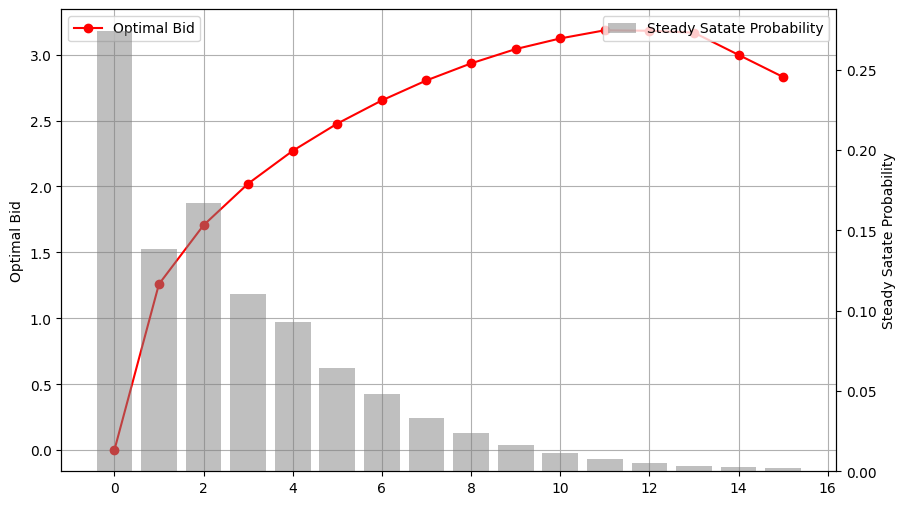

In [55]:
A = 15
mu = 1.0
lam = 0.2
r = 5.0
c = 0.2
gamma = 1.0
array_s = np.array([1 if i == 2 else 0 for i in range(A + 1)])

base_case_analysis(array_s, r, mu, c, lam, A, gamma)

## 6.2 Evaluating the Accuracy of the Heuristic

In [3]:
# Evaluating the Accuracy of the Heuristic
def winning_probability_inverse(w: float):
    return -np.log(1 - w) / 0.4


def winning_probability_inverse_derivative(w: float):
    return 1 / (0.4 * (1 - w))


def solve_dp(N: int, A: int, T:int, s: int, r: float, mu: float, C: float, c: float, lam: float):
    """
    Solve the dynamic programming problem for the system
    N: type of campaigns
    A: maximum number of customers in the system
    s: number of requests of customers of a campaign, array_s[s] = 1 and array_s[i] = 0 for i != s
    r: reward per unit of service
    mu: service rate
    C: terminal cost, which is the cost per unserved customers at the end of the time period
    c: cost per unit of time
    lam: arrival rate
    """
    dp = np.zeros([A + 1] * N + [T + 1])
    dp[..., 0] = C * np.sum(np.indices([A + 1] * N), axis=0) # initial condition

    for t in tqdm(range(1, T + 1)):
        for state in product(range(A + 1), repeat=N):
            W = dp[state + (t - 1,)]
            w = np.zeros(N)
            for i in range(N):
                state_i = list(state)
                state_i[i] = max(0, state_i[i] - 1)
                delta_W = W - dp[tuple(state_i) + (t - 1,)]
                dp_equation = lambda x: r - delta_W - winning_probability_inverse(x[0]) - x[0] * winning_probability_inverse_derivative(x[0]) 
                w[i] = fsolve(dp_equation, [0.5])[0]
                if w[i] < 0 or w[i] > 1:
                    raise ValueError() # w[i] should be in [0, 1]

            # choosing the optimal w and i
            optimal_w = max(w)
            optimal_i = np.argmax(w)
            optimal_state = list(state)
            optimal_state[optimal_i] = max(0, optimal_state[optimal_i] - 1)
            optimal_W = dp[tuple(optimal_state) + (t - 1,)]

            res = mu * (optimal_w * (r - winning_probability_inverse(optimal_w) + optimal_W) + (1 - optimal_w) * W) / (lam * N + mu) - c * sum(state) / (lam * N + mu)
            for i in range(N):
                state_i = list(state)
                state_i[i] = min(A, state_i[i] + s)
                res += dp[tuple(state_i) + (t - 1,)] * lam / (lam * N + mu)
            dp[state + (t,)] = res

    return dp[..., -1]

The results are a bit different from those in the paper, probably due to computatinal accuracy.

In [5]:
N = 3
A = 5
T = 300
s = 2
r = 5
mu = 3
C = 1
c = 0.2
lam = 0.2
gamma = 1.0
array_s = np.array([1 if i == s else 0 for i in range(A + 1)])

gerenal_dp = solve_dp(N, A, T, s, r, mu, C, c, lam) # general solution
heuristic_dp = solve_dp(1, A, T, s, r, mu / N, C, c, lam) # heuristic solution, considering only one type of ad
steady_state = solve_steady_state(array_s, r, mu, c, lam, A, gamma)
x = steady_state.x[:A + 1]

print('General Solution:', (np.einsum('i, j, k -> ijk', x, x, x) * gerenal_dp).sum()) # probabilities of combined states
print('Heuristic Solution:',(x * heuristic_dp).sum())

100%|██████████| 300/300 [00:00<00:00, 2687.52it/s]

General Solution: 377.6078498296796
Heuristic Solution: 334.46449464763856


In [6]:
N = 2
A = 5
T = 300
s = 2
r = 5
mu = 3
C = 1
c = 0.2
lam = 0.2
gamma = 1.0
array_s = np.array([1 if i == s else 0 for i in range(A + 1)])

gerenal_dp = solve_dp(N, A, T, s, r, mu, C, c, lam) # general solution
heuristic_dp = solve_dp(1, A, T, s, r, mu / N, C, c, lam) # heuristic solution, considering only one type of ad
steady_state = solve_steady_state(array_s, r, mu, c, lam, A, gamma)
x = steady_state.x[:A + 1]

print('General Solution:', (np.einsum('i, j, k -> ijk', x, x, x) * gerenal_dp).sum()) # probabilities of combined states
print('Heuristic Solution:',(x * heuristic_dp).sum())

100%|██████████| 300/300 [00:00<00:00, 2764.43it/s]

General Solution: 418.64210633176344
Heuristic Solution: 402.372001141717


## 6.4 Sensitivity Analysis for the Input Parameters

### 6.4.1 Arrival Rate of Transactions

In [37]:
def sensivity_analysis(param_list, param_name, max_A, A=15, mu=1.0, lam=0.2, r=5.0, c=0.2, gamma=1):
    """
    Perform sensitivity analysis on the system parameters
    param_list: list of parameter values to analyze
    param_name: name of the parameter to analyze (e.g., 'mu', 'lam', 'r', 'c', 'gamma')
    max_A: maximum number of customers in the system
    A: initial number of customers in the system (default is 15)
    Other parameters: mu, lam, r, c, gamma (default values)
    """
    array_s = np.array([1 if i == 2 else 0 for i in range(A + 1)])
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    profit = []
    for param in param_list:
        kwargs = {'A': A, 'mu': mu, 'lam': lam, 'r': r, 'c': c, 'gamma': gamma}
        kwargs[param_name] = param
        solution = solve_steady_state(array_s, **kwargs)
        p = solution.fun * -1
        profit.append(p)
        x, b = solution.x[:A + 1], solution.x[A + 1:]
        plt.plot(list(range(A + 1)), b, label=f'{param_name}: {param}', marker='o')
    plt.grid()
    plt.xlabel('System State')
    plt.ylabel('Optimal Bid')
    plt.legend()

    A_list = list(range(1, max_A + 1))
    optimal_A = []
    optimal_profit = []

    for param in param_list:
        kwargs = {'A': A, 'mu': mu, 'lam': lam, 'r': r, 'c': c, 'gamma': gamma}
        kwargs[param_name] = param
        best_A = 0
        best_profit = -np.inf
        for A_candidate in A_list:
            kwargs['A'] = A_candidate
            array_s = np.array([1 if i == 2 else 0 for i in range(A_candidate + 1)])
            solution = solve_steady_state(array_s, **kwargs)
            p = solution.fun * -1
            if p > best_profit:
                best_profit = p
                best_A = A_candidate
        optimal_A.append(best_A)
        optimal_profit.append(best_profit)

    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(list(map(str, param_list)), optimal_profit, label='Optimal Profit', color='red', marker='o')
    plt.plot(list(map(str, param_list)), profit, label='Profit (A = 15)', color='blue', marker='o')
    plt.xlabel(f'{param_name[0].upper() + param_name[1:]}')
    plt.ylabel('Profit Rate')
    plt.legend(loc='upper left')
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Optimal Queue Capacity')
    plt.bar(list(map(str, param_list)), optimal_A, label='Optimal Capacity', color='grey', alpha=0.3)
    plt.legend(loc='upper right')

    # 改变字体大小
    plt.rcParams.update({'font.size': 14})
    plt.tight_layout()
    plt.show()

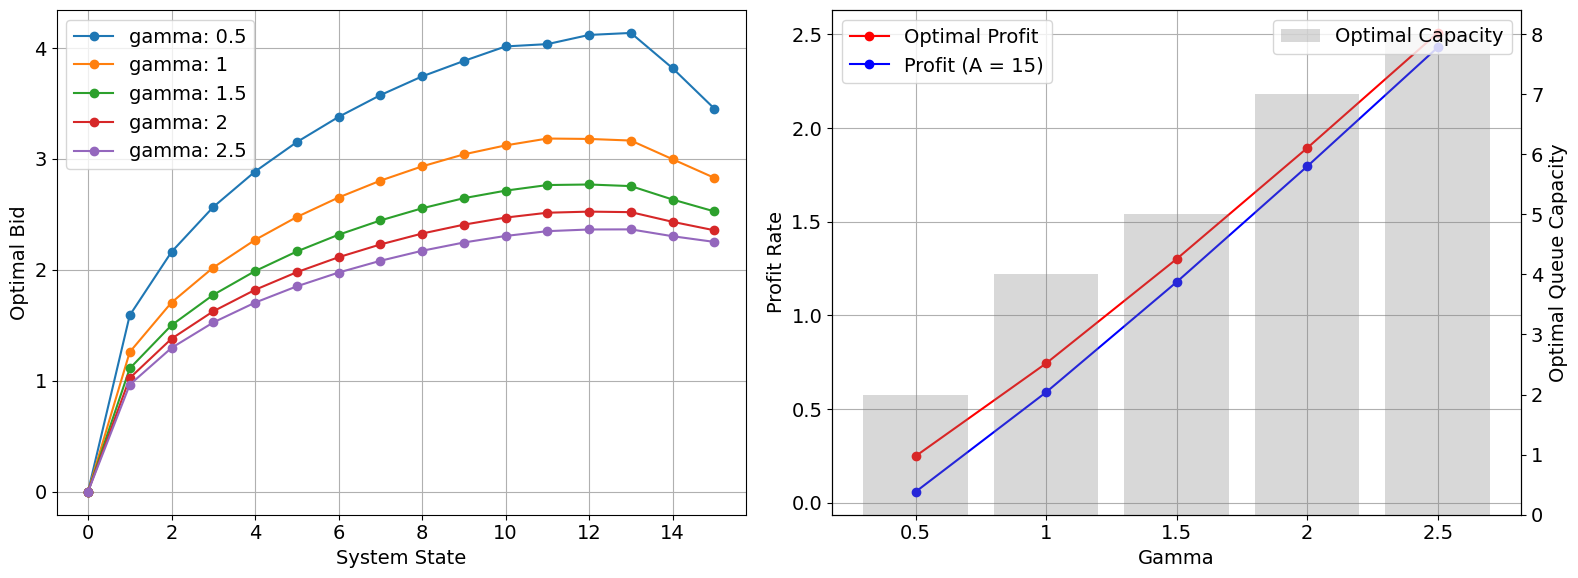

In [38]:
gamma_list = [0.5, 1, 1.5, 2, 2.5]
param_name = 'gamma'
max_A = 15
sensivity_analysis(gamma_list, param_name, max_A)

### 6.4.2 Arrival Rate of Viewers

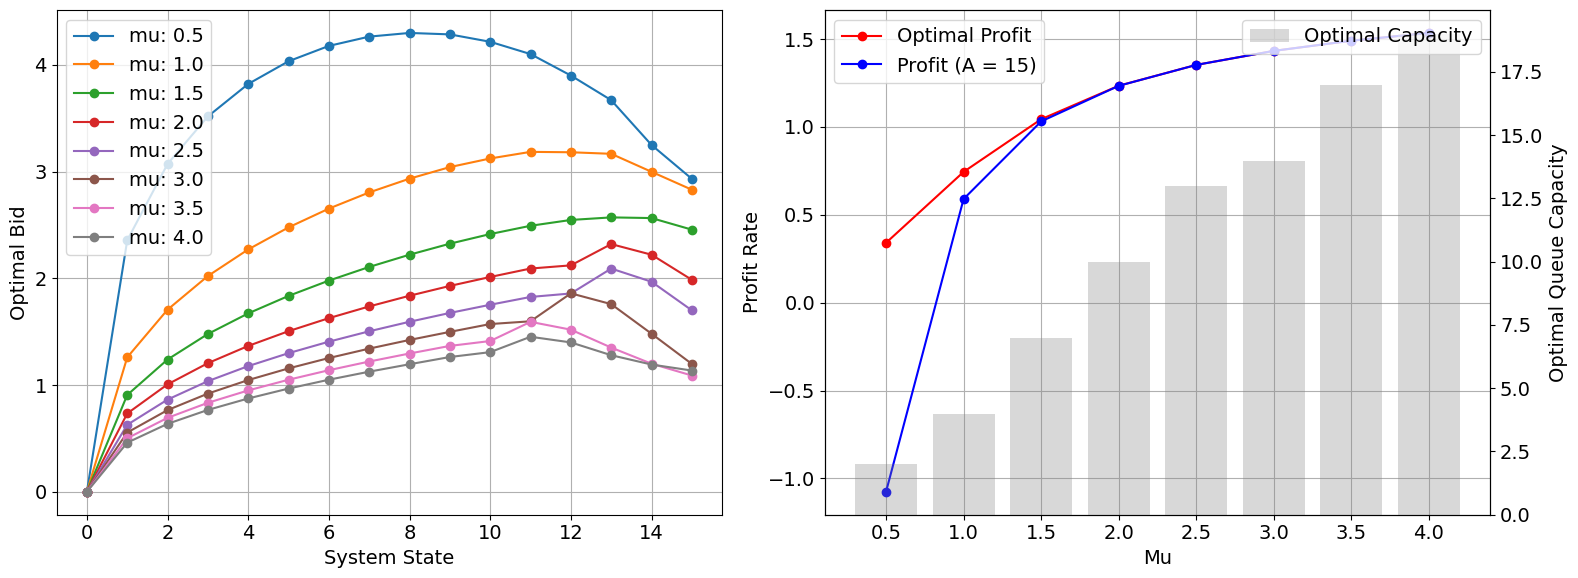

In [39]:
mu_list = [0.5 * x for x in range(1, 9)]
param_name = 'mu'
max_A = 20
sensivity_analysis(mu_list, param_name, max_A)

### 6.4.3 Arrival Rate of Campaigns

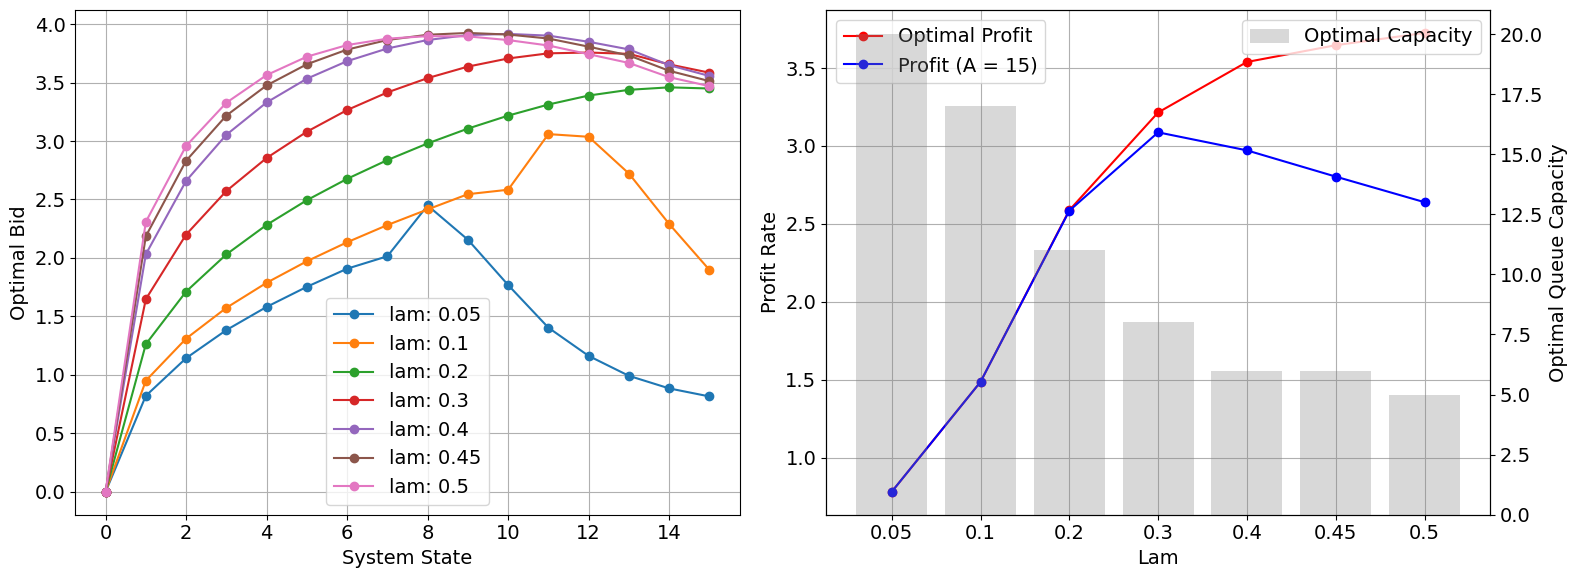

In [40]:
lam_list = [0.05, 0.10, 0.20, 0.30, 0.40, 0.45, 0.50]
param_name = 'lam'
max_A = 20
sensivity_analysis(lam_list, param_name, max_A, r=10.0)

### 6.4.4 Financial Parameters r and c

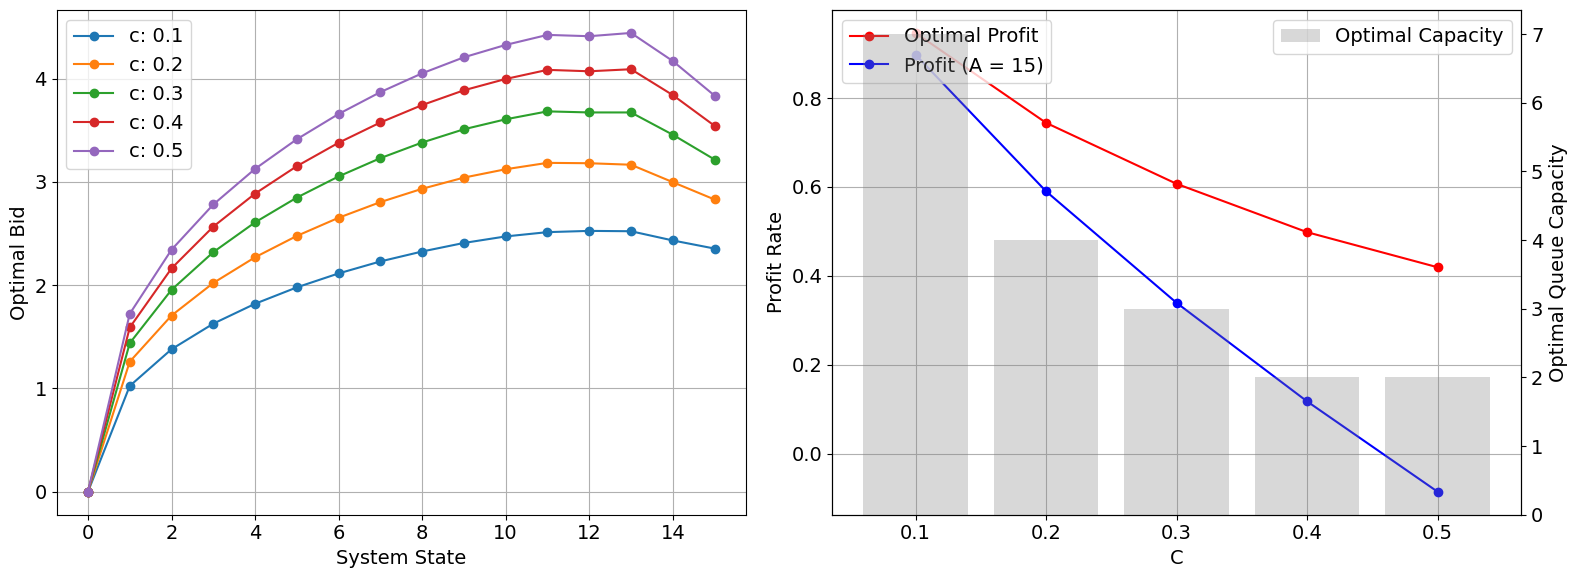

In [41]:
c_list = [0.1, 0.2, 0.3, 0.4, 0.5]
param_name = 'c'
max_A = 20
sensivity_analysis(c_list, param_name, max_A)

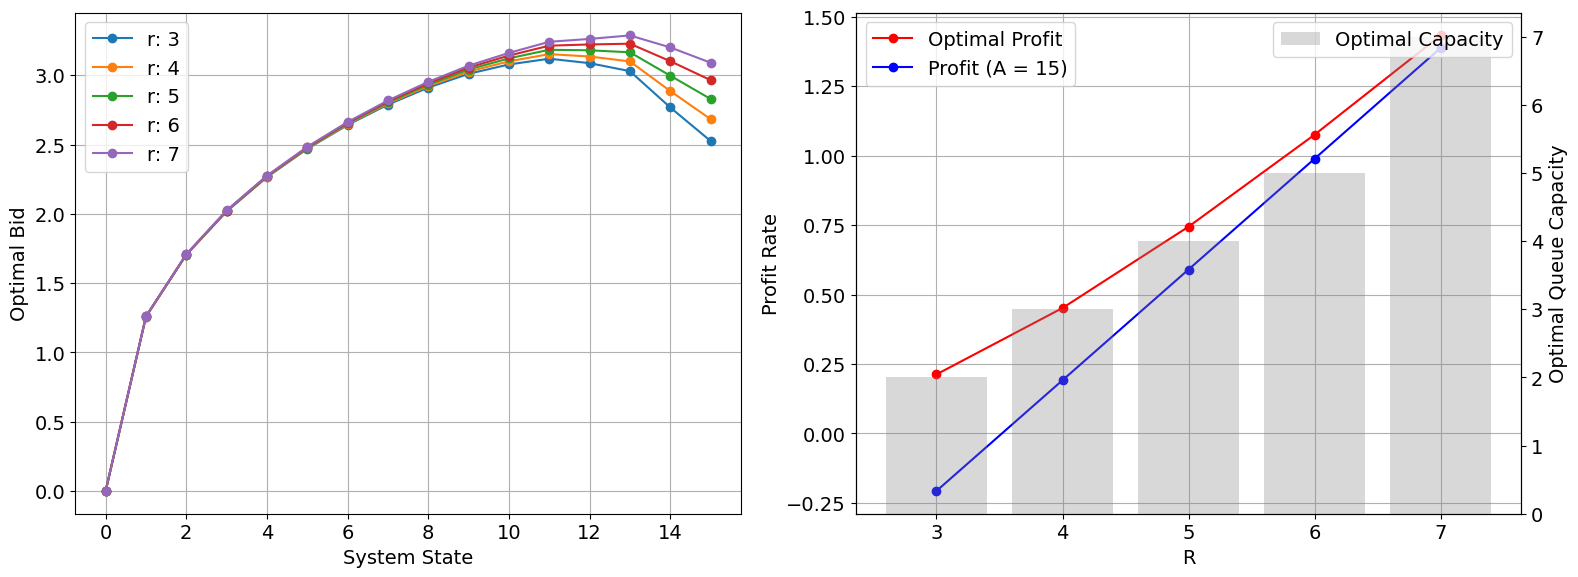

In [42]:
r_list = [3, 4, 5, 6, 7]
param_name = 'r'
max_A = 10
sensivity_analysis(r_list, param_name, max_A)

## Extra Analysis

Here we conduct the sensivity analysis of parameter s, which is not covered in the paper.

In [47]:
# A = 15
# mu = 1.0
# lam = 0.2
# r = 5.0
# c = 0.2
# gamma = 1.0
# s_list = [1, 2, 3, 4, 5]

# plt.figure(figsize=(10, 6))
# for s in s_list:
#     array_s = np.array([1 if i == s else 0 for i in range(A + 1)])
#     solution = solve_steady_state(array_s, r, mu, c, lam, A, gamma)
#     p = solution.fun * -1
#     x, b = solution.x[:A + 1], solution.x[A + 1:]
#     plt.plot(list(range(A + 1)), b, label=f's: {s}', marker='o')

# plt.grid()
# plt.xlabel('System State')
# plt.ylabel('Optimal Bid')
# plt.legend()
# plt.show()

Throughout the preceding analysis (and the paper) we assume that array_s takes the value of s with probability one. Now we consider some common distributions (other settings are the same with the base case).

Max Bid: 2.391640118476693
Probability of Empty Queue: 0.02193835363799329
Average Profit Rate: -0.6618762571243952


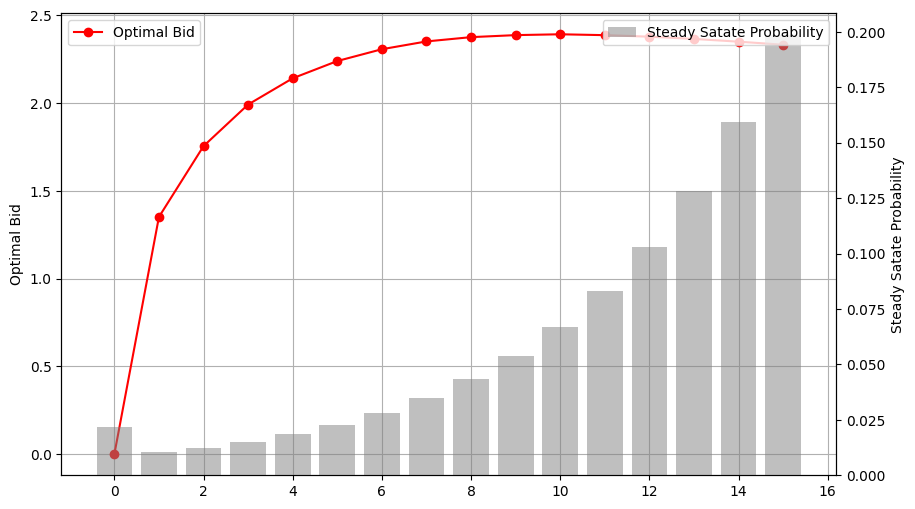

In [52]:
A = 15
mu = 1.0
lam = 0.2
r = 5.0
c = 0.2
gamma = 1.0
plt.rcParams.update({'font.size': 10})

# Using a uniform distribution for array_s
array_s = np.array([0] + [1 / A] * A)
base_case_analysis(array_s, r, mu, c, lam, A, gamma)

Max Bid: 2.364715718003818
Probability of Empty Queue: 0.013509844833347762
Average Profit Rate: -0.752971994969901


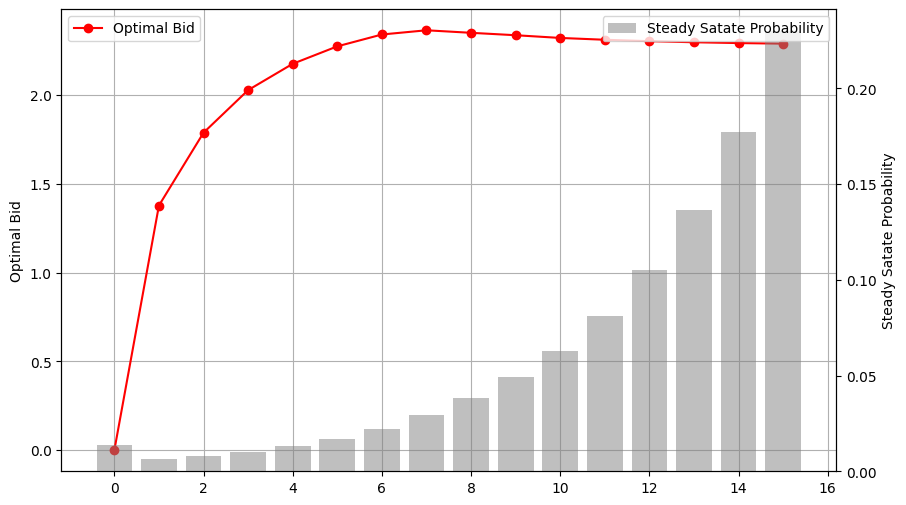

In [53]:
# Using a normal distribution for array_s
array_s = np.concatenate([np.array([0]), stats.norm.pdf(np.arange(A), loc=A / 2, scale=1)])
base_case_analysis(array_s, r, mu, c, lam, A, gamma)

Max Bid: 3.0523382493856586
Probability of Empty Queue: 0.17699238918183263
Average Profit Rate: 0.2165796144173766


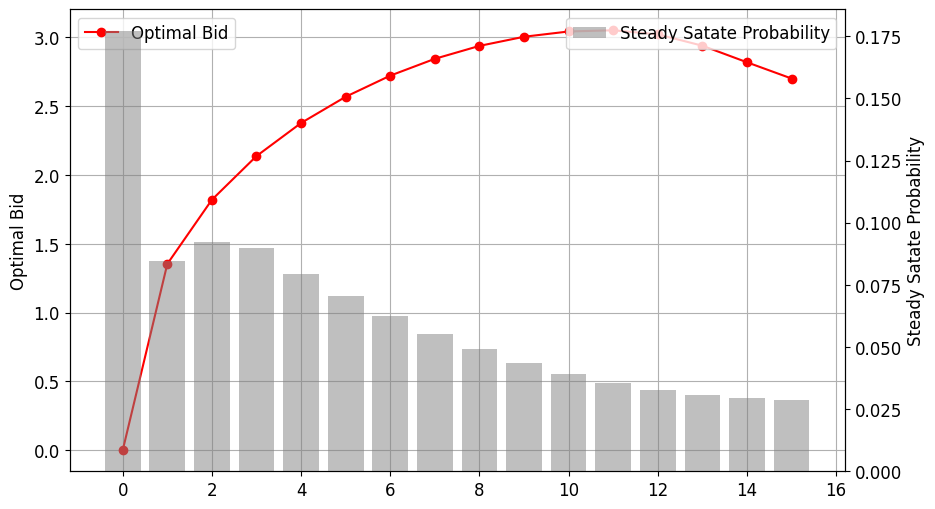

In [51]:
# Using a normal distribution for array_s with a smaller mean
array_s = np.concatenate([np.array([0]), stats.norm.pdf(np.arange(A), loc=A / 10, scale=1)])
base_case_analysis(array_s, r, mu, c, lam, A, gamma)